In [1]:
import os

import pandas as pd
from clearml import Task

import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [2]:
# project_name = 'AA_attack_run_GOLDEN'
# #project_name = 'attacks_examples'
# tags_filter = ["__$all", 'Dima', 'Strawberry']
# tags_filter = []

# tags_iteration = [['Dmitry'], ['Sophie']]
# metrics = pd.DataFrame()

# for tags in tags_iteration:
#     tasks = Task.get_tasks(project_name=project_name, tags=tags)
#     # task_example = tasks[-1]
#     print(len(tasks))

#     metrics_ = pd.DataFrame()

#     for task in tasks:
#         task_name = task.name
#         print(task_name) 
#         scalars = task.get_reported_scalars()
#         # experiments[task_name] = scalars
#         #scalars = [scalar for scalar in scalars scalar]

#         df_all_metrics = pd.DataFrame([])

#         for metric_name in scalars:
#             if metric_name[0] == ':':
#                 continue
#             data = scalars[metric_name][metric_name]
#             iters = data['x']
#             values = data['y']
#             df_metric = pd.DataFrame(index=data['x'], columns=[data['name']], data=data['y'])
#             df_all_metrics = df_all_metrics.join(df_metric, how='right')

#         df_all_metrics = df_all_metrics.reset_index()
#         df_all_metrics = df_all_metrics.rename(columns={'index': 'iters'})
#         df_all_metrics['exp_name'] = task_name
#         metrics_ = pd.concat([metrics_, df_all_metrics])
#     metrics = pd.concat([metrics, metrics_])

# metrics.to_csv('../results/attack_metrics_clearml_3.csv')
# metrics

In [87]:
def draw_scatter_pair_metrics(
    df, 
    x_col, 
    y_col, 
    x_col_name=None, 
    y_col_name=None, 
    title=None,
    fontsize=16,
    legend=True,
    legend_position='out',
    savepath=''
):

    n_colors = df['dataset'].nunique()

    # Цветовая палитра для датасетов
    palette = sns.color_palette("hls", n_colors)

    # Формы точек для моделей
    markers = ['o', 's', 'D', '^', '<', '>']

    plt.figure(figsize=[5, 5], dpi=300)

    # Создание scatterplot
    sns.scatterplot(
        x=x_col, 
        y=y_col, 
        hue='dataset', 
        style='model',
        data=df,
        palette=palette,
        markers=markers,
        s=100,
    )

    if not x_col_name:
        x_col_name = x_col
    
    if not y_col_name:
        y_col_name = y_col

    # Настройка графика
    plt.xlabel(x_col_name, fontsize=fontsize)
    plt.ylabel(y_col_name, fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)

    # Диагональная линия
    plt.plot([0, 1], [0, 1], 'k--')

    if title:
        plt.title(title)

    # Легенда
    if legend and legend_position == 'out':
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=fontsize)
    elif legend and legend_position == 'in':
        plt.legend(bbox_to_anchor=(1.3, 0), loc='lower right', fontsize=fontsize-4)
    else:
        plt.legend([],[], frameon=False, fontsize=fontsize)
    plt.grid()
    # plt.title('Изменение метрики атаки с дискриминатором и без дискриминатора')
    # # Отображение графика
    # plt.tight_layout()

    if len(savepath) > 0:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()


In [88]:
def load_local_data(datasets, models, prefixes, flag_test=True):
    results = pd.DataFrame()

    for dataset in datasets:
        df_dataset = pd.DataFrame()
        for model in models:
            model_data = pd.DataFrame()
            path = f'../results/{dataset}/{model}/attack'

            try:
                experiments = os.listdir(path)                
                for exp_folder in experiments:
                    if exp_folder[0] == '.':
                        continue
                    exp_path = os.path.join(path, exp_folder)
                    exp_params = [exp for exp in os.listdir(exp_path) if '.csv' in exp]
                    
                    exp_data = pd.DataFrame()
                    for param_file in exp_params:
                        metric_path = os.path.join(exp_path, param_file)
                        param_df = pd.read_csv(metric_path)
                        #print(metric_path)
                        
                        exp_full_name = param_file.replace('.csv', '')
                        # exp_full_name
                        # for prefix in prefixes:

                        #     print(prefix in exp_name)
                        #     exp_name = exp_name.replace(exp_full_name, '')
                        #     while exp_name[-1] == '_':
                        #         exp_name = exp_name[:-1]
                        param_df['full_exp_name'] = exp_full_name
                        
                        param_df.columns = [col.strip() for col in param_df.columns]

                        exp_data = pd.concat([exp_data, param_df], axis=0)
                    
                    exp_name = exp_folder
                    exp_data['experiment'] = exp_name

                    exp_data['model'] = model
                    exp_data['dataset'] = dataset

                    if len(exp_data.columns) > 22 or flag_test:
                        flag_test = False
                    model_data = pd.concat([model_data, exp_data], axis=0)
            except:
                print(path)
            
            df_dataset = pd.concat([df_dataset, model_data], axis=0)
        results = pd.concat([results, df_dataset], axis=0)

    return results

# Load 

In [89]:
# dataset = 'PowerCons'
# model = 'ResidualCNN'

results = load_local_data(
    datasets = ['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint', 'Coffee', 'FreezerRegularTrain'],
    models = ['ResidualCNN', 'PatchTST', 'S4', 'RNNA'], # ['S4', 'ResidualCNN', 'TST', 'PatchTST', 'RNNA']
    prefixes = ['fast_run', 'test'],
    flag_test = True,
)


mask = \
    (results['full_exp_name'].str.contains('pgd')) | \
    (results['full_exp_name'].str.contains('harmonic')) | \
    (results['full_exp_name'].str.contains('hypercones')) | \
    (results['full_exp_name'].str.contains('simba')) | \
    (results['full_exp_name'].str.contains('kll2')) | \
    (
        results['full_exp_name'].str.contains('fgsm') & \
        (results['dataset'] == 'PowerCons') & results['model'].isin(['PatchTST', 'ResidualCNN', 'S4', 'RNNA'])
)
results = results[mask].rename(columns={'step_id': 'iters'})
results['exp_name'] = results['full_exp_name']

In [90]:
res_check = results[~results['full_exp_name'].str.contains('pgd')]

res_check['exp_name'] = res_check['exp_name'].str.replace('__', '|')
res_check['exp_name_no_params'], res_check['exp_params'] = res_check['exp_name'].str.split('|', n=1).str

res_check['exp_params'] = res_check['exp_params'].str.split('|')
res_check['dataset'].unique()

/tmp/ipykernel_8500/3510677327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_check['exp_name'] = res_check['exp_name'].str.replace('__', '|')
/tmp/ipykernel_8500/3510677327.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  res_check['exp_name_no_params'], res_check['exp_params'] = res_check['exp_name'].str.split('|', n=1).str
/tmp/ipykernel_8500/3510677327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_check['exp_name_no_params'], res_check['

array(['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint',
       'Coffee', 'FreezerRegularTrain'], dtype=object)

In [91]:
bad_exp = [exp for exp in res_check.full_exp_name.unique() if len(exp) < 30]
res_check[res_check['full_exp_name'].isin(bad_exp)]['exp_name'].unique()

array([], dtype=object)

# Transform

In [92]:
metrics = pd.read_csv('../results/attack_metrics_clearml_3.csv', index_col=0)

na_mask = metrics.T.isna().sum() > 0
metrics = metrics[~na_mask]

metrics.head()

,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,L1,PR,PROB_HID,ROC,ROC_AUC_DISC,ROUGHNESS,ROUGHNESS_NORM,exp_name
0,0,0.977895,1.000000,0.982456,1.000000,0.000000,0.022005,0.977995,0.000000,0.000000,0.000000,0.965266,0.021848,0.977895,1.000000,0.044127,1.000000,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
1,1,0.951579,0.973089,0.500175,0.973684,0.509884,0.047553,0.952447,0.034565,0.086994,1.505000,0.922534,0.022083,0.951579,0.490116,0.045802,1.037978,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
2,2,0.918246,0.939003,0.500702,0.940351,0.475143,0.079333,0.920667,0.036561,0.135964,2.775684,0.873987,0.024397,0.918246,0.524857,0.047355,1.073161,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
3,3,0.881404,0.901328,0.501579,0.903509,0.412841,0.114344,0.885656,0.039878,0.179086,4.075333,0.826099,0.029835,0.881404,0.587160,0.049146,1.113756,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
4,4,0.843860,0.862935,0.503509,0.865965,0.343764,0.151206,0.848794,0.047138,0.210030,5.184747,0.782925,0.041206,0.843860,0.656236,0.051147,1.159093,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001


In [93]:
metrics['iters'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [94]:
metrics = pd.concat([metrics, results])

In [95]:
metrics['exp_name'] = metrics['exp_name'].str.replace('__', '|')
metrics['exp_name_no_params'], metrics['exp_params'] = metrics['exp_name'].str.split('|', n=1).str

metrics['exp_params'] = metrics['exp_params'].str.split('|')
metrics['exp_params'] = metrics['exp_params'].apply(lambda x_list: {x.split('=')[0]:x.split('=')[1] for x in x_list})
metrics = pd.concat([metrics.reset_index(drop=True), pd.json_normalize(metrics['exp_params'])], axis=1)
metrics = metrics.drop(columns=['exp_params'])

metrics['_'], metrics['model'], metrics['seed'], metrics['dataset'], metrics['attack'] = \
    metrics['exp_name_no_params'].str.split('_', n=4).str
metrics = metrics.drop(columns=['_'])

metrics['attack'] = metrics['attack'].apply(
    lambda x: '_'.join([word for word in x.split('_') if word != 'attack'])
)
metrics['attack_type'] = metrics['attack'].str.split('_').str[0]
metrics['disc_attack'] = metrics['attack'].str.contains("disc")

metrics.head()

/tmp/ipykernel_8500/2431537609.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  metrics['exp_name_no_params'], metrics['exp_params'] = metrics['exp_name'].str.split('|', n=1).str
/tmp/ipykernel_8500/2431537609.py:9: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  metrics['_'], metrics['model'], metrics['seed'], metrics['dataset'], metrics['attack'] = \


,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,...,alpha,eta,smoothness,mu,norm_coef,delta,seed,attack,attack_type,disc_attack
0,0.0,0.977895,1.000000,0.982456,1.000000,0.000000,0.022005,0.977995,0.000000,0.000000,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
1,1.0,0.951579,0.973089,0.500175,0.973684,0.509884,0.047553,0.952447,0.034565,0.086994,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
2,2.0,0.918246,0.939003,0.500702,0.940351,0.475143,0.079333,0.920667,0.036561,0.135964,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
3,3.0,0.881404,0.901328,0.501579,0.903509,0.412841,0.114344,0.885656,0.039878,0.179086,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
4,4.0,0.843860,0.862935,0.503509,0.865965,0.343764,0.151206,0.848794,0.047138,0.210030,...,0.0001,NaN,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True


In [96]:
hid_col = 'F1'
conc_col = 'F1_DISC'

metrics['EFF'] = 1 - metrics[hid_col]
metrics['CONC'] = 1 - metrics[conc_col]
metrics['F_EFF_CONC'] = 2 * metrics['EFF']  * metrics['CONC'] / (metrics['EFF'] + metrics['CONC'])

In [97]:
mask = (metrics['model'] == 'ResidualCNN') & (metrics['dataset'] == 'PowerCons') # & (metrics['attack'] == 'fgsm')
metrics[mask]['attack'].unique()

array(['fgsm_harmonic', 'fgsm', 'kll2', 'fgsm_disc_hypercones', 'simba',
       'pgd_disc', 'simba_disc', 'pgd', 'fgsm_disc'], dtype=object)

# Vizualization

In [98]:
metric_name = 'F_EFF_CONC'

eff_thr = 0.9
pgd_fgsm_iter_thr = 40
simba_iter_thr = 1200
kll2_iter_thr = 400

filter_start_point_mask = (metrics['EFF'] > eff_thr) | \
    (((metrics['attack'].str.contains('fgsm')) | (metrics['attack'].str.contains('pgd'))) & (metrics['iters'] >= pgd_fgsm_iter_thr)) | \
    ((metrics['attack'].str.contains('simba')) & (metrics['iters'] >= simba_iter_thr)) | \
    ((metrics['attack'].str.contains('kll2')) & (metrics['iters'] >= kll2_iter_thr))

filter_start_point_mask = filter_start_point_mask & (metrics['dataset'] != 'Wafer')
grouped_data = metrics[filter_start_point_mask].groupby(by=['dataset', 'model', 'attack'], as_index=False).agg({metric_name: max})
agg_data = grouped_data.pivot(index=['dataset', 'model'], columns='attack', values=metric_name).reset_index()
# agg_data = agg_data.dropna(subset=['fgsm', 'fgsm_disc'])
agg_data

attack,dataset,model,fgsm,fgsm_disc,fgsm_disc_hypercones,fgsm_harmonic,kll2,pgd,pgd_disc,simba,simba_disc
0,Coffee,PatchTST,0.464286,1.000000,NaN,1.000000,0.421839,0.133314,0.557249,NaN,NaN
1,Coffee,RNNA,0.661935,1.000000,NaN,1.000000,1.000000,0.339363,1.000000,NaN,NaN
2,Coffee,ResidualCNN,1.000000,1.000000,NaN,1.000000,0.964267,0.035749,1.000000,NaN,NaN
3,Coffee,S4,0.892537,1.000000,NaN,1.000000,0.894830,0.188192,0.860543,NaN,NaN
4,FreezerRegularTrain,PatchTST,0.051125,0.999649,NaN,0.995098,0.457138,0.536994,1.000000,NaN,NaN
5,FreezerRegularTrain,RNNA,0.075926,0.943598,NaN,0.468925,0.242931,0.463535,0.537275,NaN,NaN
6,FreezerRegularTrain,ResidualCNN,0.996297,0.997156,NaN,0.994310,0.991560,0.647562,0.978764,NaN,NaN
7,FreezerRegularTrain,S4,0.089920,0.951026,NaN,0.850180,0.460167,0.742390,0.934578,NaN,NaN
8,GunPoint,PatchTST,0.019608,0.802195,0.421094,0.767398,0.503475,0.360716,0.813796,NaN,NaN
9,GunPoint,RNNA,0.013158,0.512798,0.623632,0.459635,0.926693,0.179174,0.468627,NaN,NaN


In [99]:
model_mapping = {
    'RNNA': 'RNNAttention',
    'PatchTST': 'PatchTST',
    'S4': 'S4',
    'ResidualCNN': 'ResCNN',
}

agg_data_table = grouped_data[(grouped_data['attack'] != 'fgsm_disc_hypercones') & (~grouped_data['attack'].str.contains('simba'))]
agg_data_table['model'] = agg_data_table['model'].map(model_mapping)
agg_data_table = agg_data_table.pivot(index=['dataset', 'attack'], columns='model', values=metric_name).reset_index()

attack_mapping = {
    'fgsm': 'Vanilla iFGSM',
    'fgsm_disc': 'iFGSM Sum Reg (ours)',
    'fgsm_harmonic': 'iFGSM Harmonic Reg (ours)',
    'kll2': 'SGM',
    'pgd': 'Vanilla PGD',
    'pgd_disc': 'PGD Sum Reg (ours)',
}
agg_data_table['attack'] = agg_data_table['attack'].map(attack_mapping)

order = [0, 4, 3, 5, 2, 1]
agg_data_new = pd.DataFrame([])

for ds_name in agg_data_table['dataset'].unique():
    agg_data_ds = agg_data_table[agg_data_table['dataset'] == ds_name].reset_index(drop=True)
    agg_data_ds = agg_data_ds.iloc[order]
    agg_data_new = pd.concat([agg_data_new, agg_data_ds])

agg_data_new.round(3).fillna('-')

/tmp/ipykernel_8500/634453506.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agg_data_table['model'] = agg_data_table['model'].map(model_mapping)


model,dataset,attack,PatchTST,RNNAttention,ResCNN,S4
0,Coffee,Vanilla iFGSM,0.464,0.662,1.000,0.893
4,Coffee,Vanilla PGD,0.133,0.339,0.036,0.188
3,Coffee,SGM,0.422,1.000,0.964,0.895
5,Coffee,PGD Sum Reg (ours),0.557,1.000,1.000,0.861
2,Coffee,iFGSM Harmonic Reg (ours),1.000,1.000,1.000,1.000
1,Coffee,iFGSM Sum Reg (ours),1.000,1.000,1.000,1.000
0,FreezerRegularTrain,Vanilla iFGSM,0.051,0.076,0.996,0.090
4,FreezerRegularTrain,Vanilla PGD,0.537,0.464,0.648,0.742
3,FreezerRegularTrain,SGM,0.457,0.243,0.992,0.460
5,FreezerRegularTrain,PGD Sum Reg (ours),1.000,0.537,0.979,0.935


In [100]:
df_nan = agg_data_table.iloc[:, 2:]

df_nan.isna().sum().sum() / (df_nan.shape[0] * df_nan.shape[1])

0.0

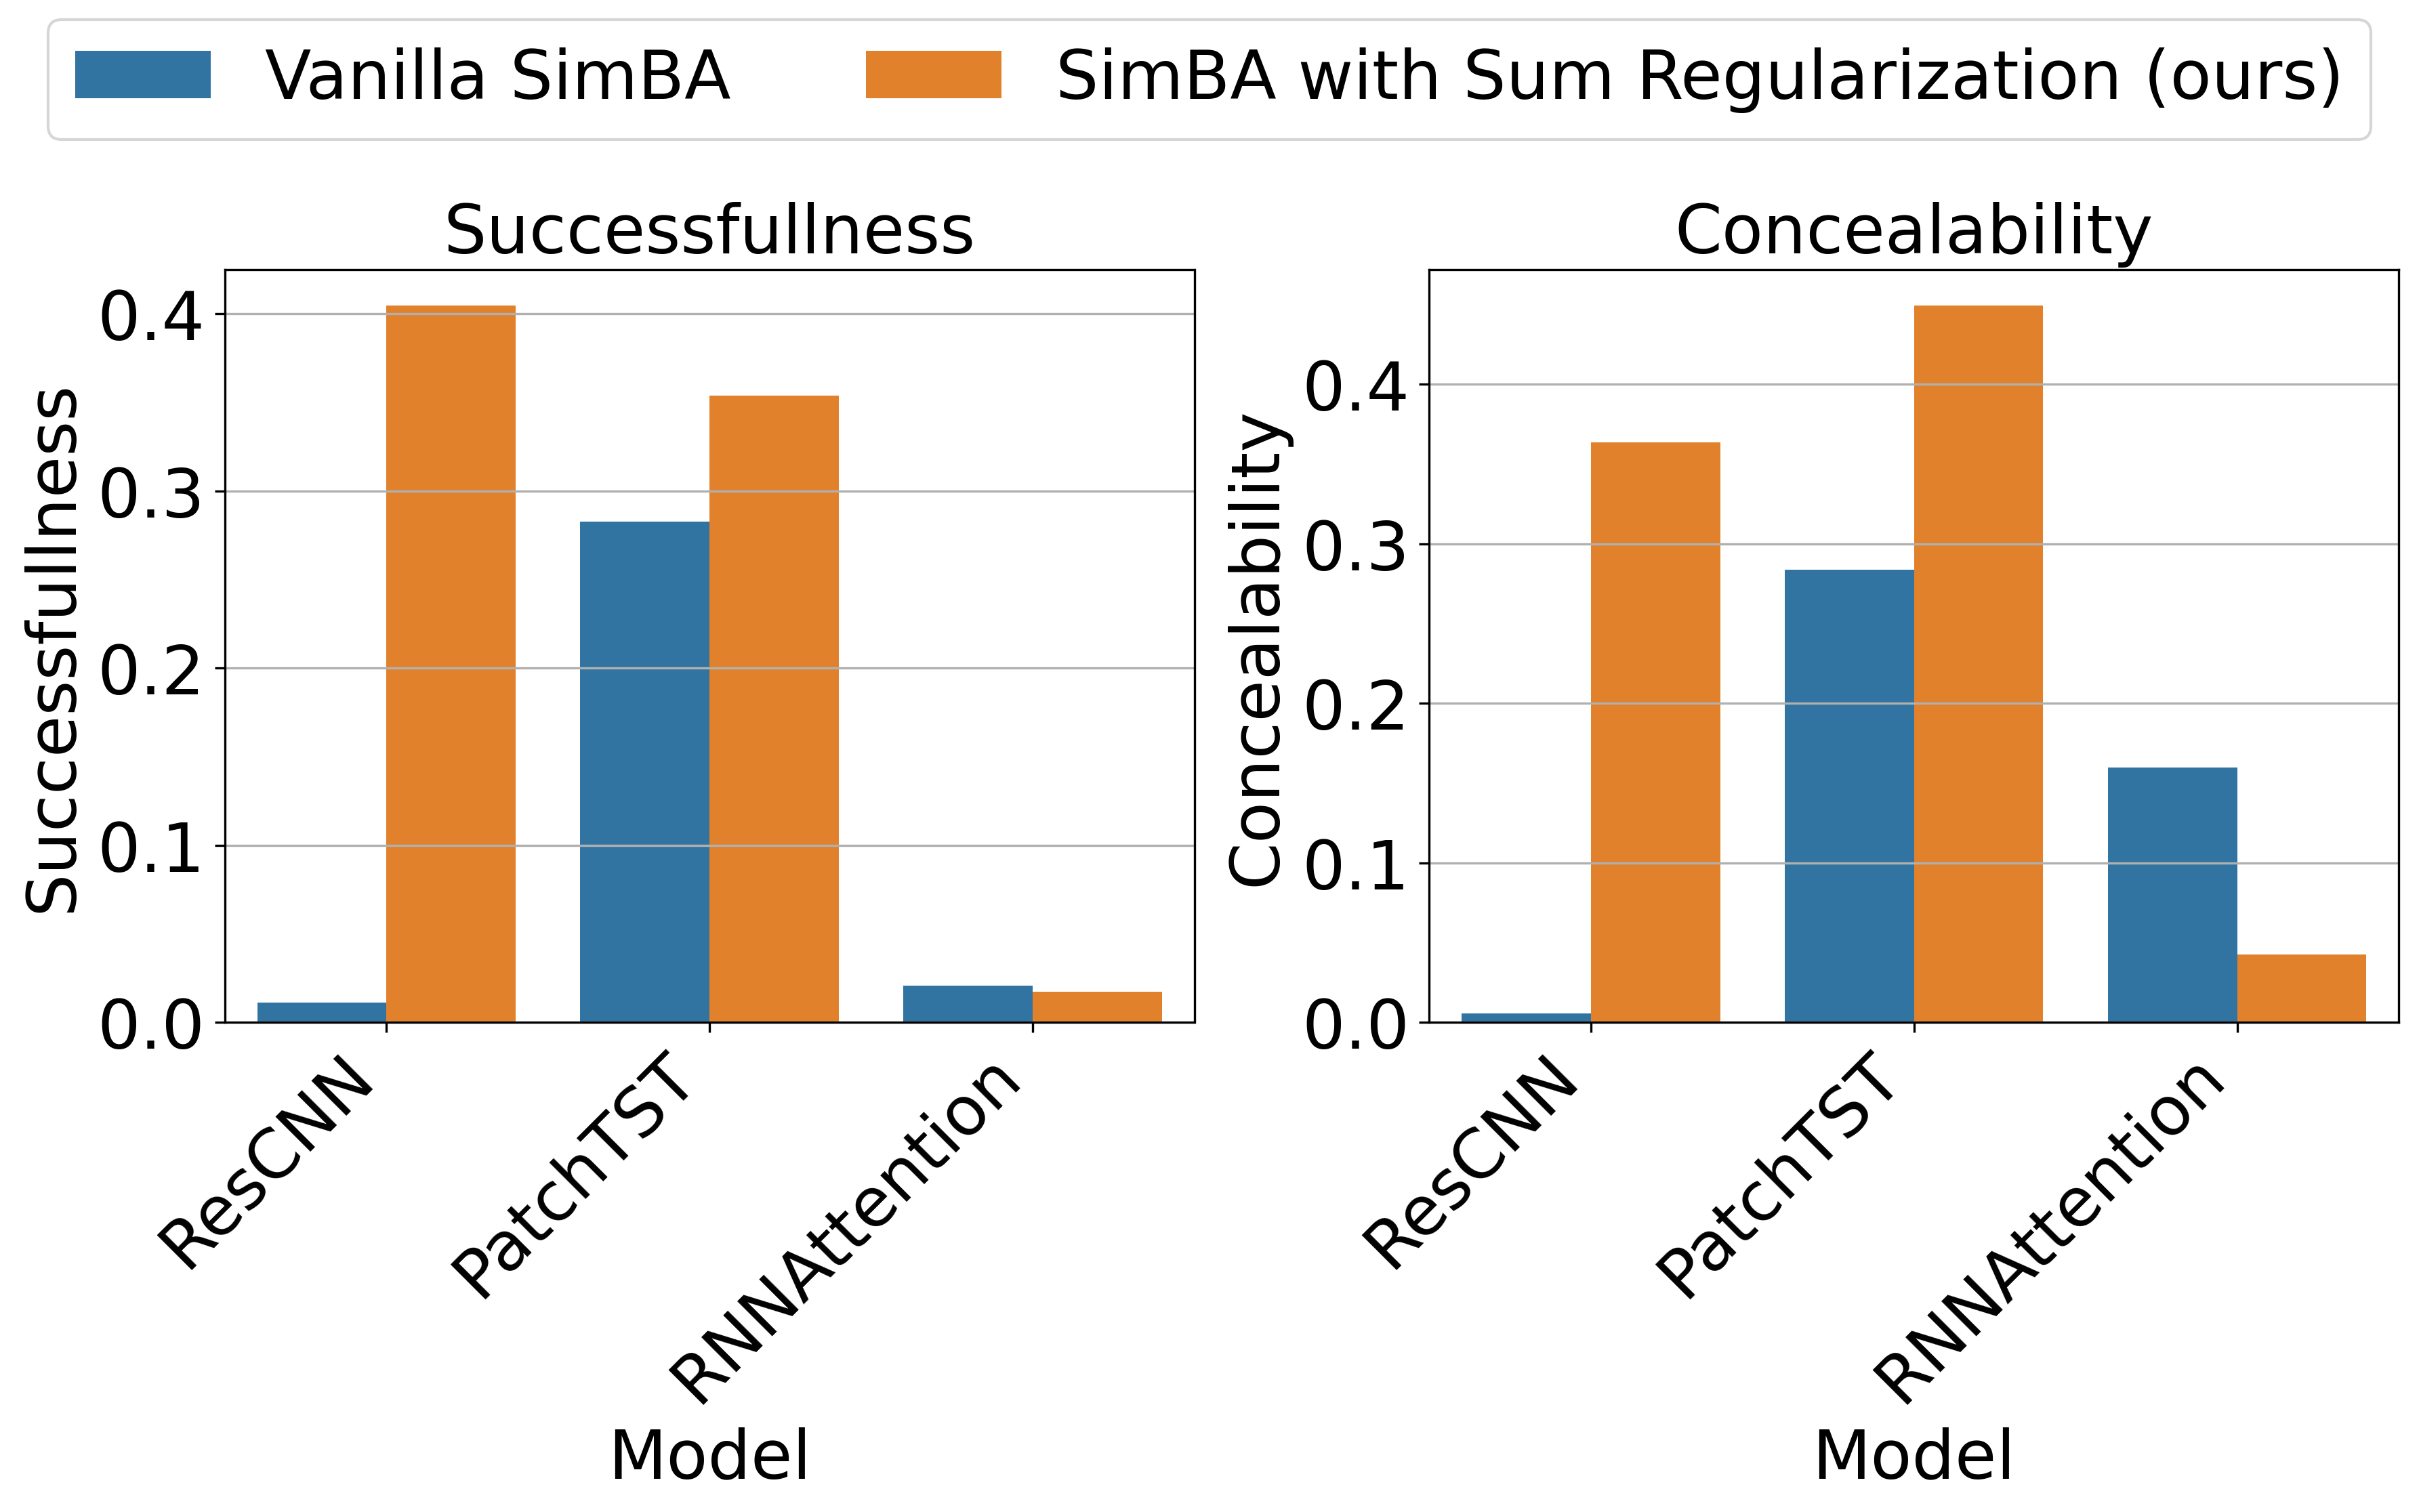

In [101]:
#simba_plot = grouped_data[grouped_data['attack'].str.contains("simba")]

filtered_metrics = metrics[filter_start_point_mask]
#filtered_metrics.groupby(by=['dataset', 'model', 'attack'])[metric_name].idxmax()
#grouped_data = metrics[filter_start_point_mask].loc[mask]

max_values = filtered_metrics.groupby(by=['dataset', 'model', 'attack'])[metric_name].transform(max)
simba_plot = filtered_metrics[filtered_metrics[metric_name] == max_values][['dataset', 'model', 'attack', metric_name, 'EFF', 'CONC']]

simba_plot = simba_plot[simba_plot['attack'].str.contains("simba")]

simba_plot = simba_plot.drop_duplicates()

simba_plot = simba_plot.melt(id_vars=['dataset', 'model', 'attack'], value_vars=['F_EFF_CONC', 'EFF', 'CONC'], var_name='metric', value_name='metric_val')

attack_mapping = {
    'simba': 'Vanilla SimBA',
    'simba_disc': 'SimBA with Sum Regularization (ours)',
}

metric_mapping = {
    'F_EFF_CONC': 'Successfullness',
    'EFF': 'Effect',
    'CONC': 'Concealability',
}

model_mapping = {
    'RNNA': 'RNNAttention',
    'PatchTST': 'PatchTST',
    'S4': 'S4',
    'ResidualCNN': 'ResCNN',
}

simba_plot['attack_label'] = simba_plot['attack'].map(attack_mapping)
simba_plot['model'] = simba_plot['model'].map(model_mapping)

fontsize=24

show_metrics = ['F_EFF_CONC', 'CONC'] #, 'EFF', 'CONC']
# Plotting
fig, axis = plt.subplots(1, len(show_metrics), figsize=(12, 7), dpi=300)

for i, (ax, met_name) in enumerate(zip(axis, show_metrics)):
    sns.barplot(data=simba_plot[simba_plot['metric'] == met_name], 
    x='model', y='metric_val', hue='attack_label', ax=ax, errorbar=None)

    ax.set_xlabel('Model', fontsize=fontsize)
    ax.set_ylabel(metric_mapping[met_name], fontsize=fontsize)
    ax.set_title(metric_mapping[met_name], fontsize=fontsize)
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.grid(axis='y')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
        tick.set_ha('right')
    # ax.legend()
    # if i == len(show_metrics) - 1:
    #     ax.legend()
    # else:
    #     ax.legend([], [], frameon=False)
    ax.get_legend().remove()  # Удаляем легенду у каждого сабплота

# Добавляем общую легенду под графиками
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels, 
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    ncol=len(labels),
    fontsize=fontsize
)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# plt.legend(title='Attack Type', bbox_to_anchor=(0.5, 1))
# plt.tight_layout()
plt.savefig("../pictures/simba.pdf", bbox_inches='tight')
plt.show()

/tmp/ipykernel_8500/2081412660.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['attack_label'] = plot_data['attack'].map(attack_mapping)
/tmp/ipykernel_8500/2081412660.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['model'] = plot_data['model'].map(model_mapping)


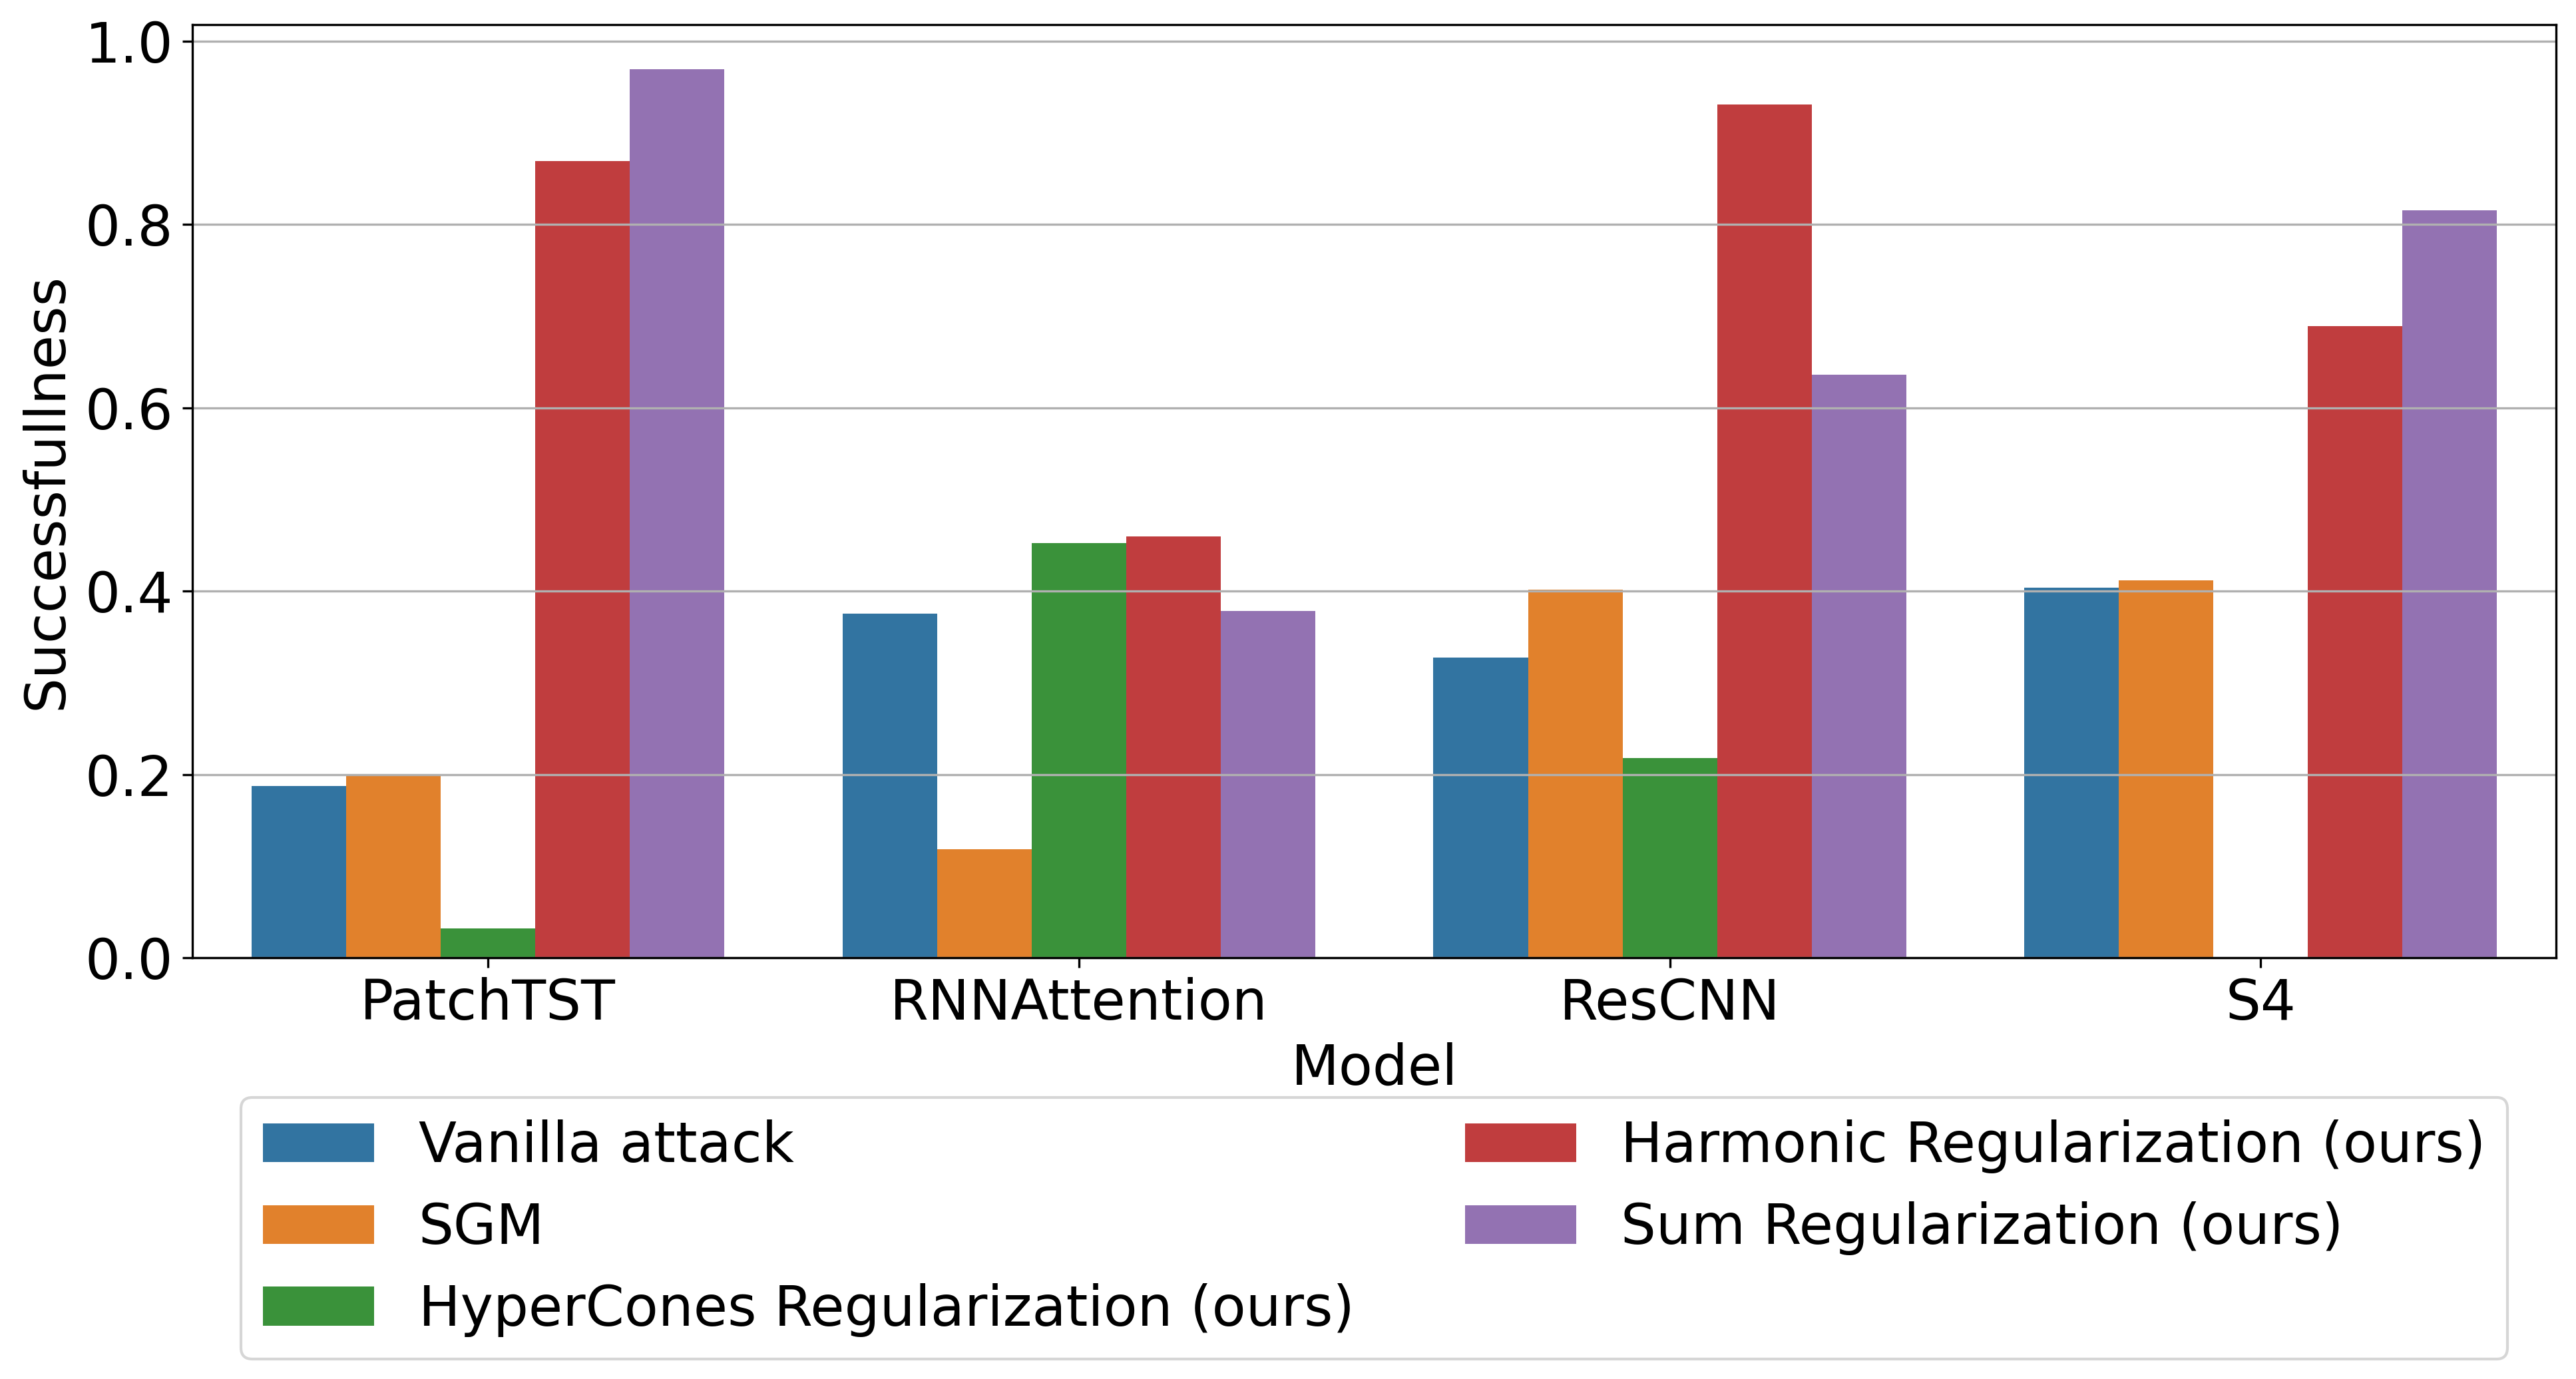

In [103]:
ds_plot = ['PowerCons'] #['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint', 'Coffee', 'FreezerRegularTrain'] # ['PowerCons', 'GunPoint']
attacks_plot = ['fgsm', 'fgsm_disc', 'fgsm_harmonic', 'fgsm_disc_hypercones', 'kll2'] #'fgsm_disc_hypercones',

plot_data = grouped_data[(grouped_data['dataset'].isin(ds_plot)) & (grouped_data['attack'].isin(attacks_plot))]

attack_mapping = {
    'fgsm': 'Vanilla attack',
    'fgsm_disc': 'Sum Regularization (ours)',
    'fgsm_harmonic': 'Harmonic Regularization (ours)',
    'fgsm_disc_hypercones': 'HyperCones Regularization (ours)',
    'kll2': 'SGM'
}

model_mapping = {
    'RNNA': 'RNNAttention',
    'PatchTST': 'PatchTST',
    'S4': 'S4',
    'ResidualCNN': 'ResCNN',
}
plot_data['attack_label'] = plot_data['attack'].map(attack_mapping)
plot_data['model'] = plot_data['model'].map(model_mapping)


order = [0, 4, 2, 3, 1]
order_alt = [0, 3, 1, 2]

fontsize=20
plot_data_new = pd.DataFrame([])

for model_name in plot_data['model'].unique():
    plot_data_model = plot_data[plot_data['model'] == model_name].reset_index(drop=True)
    if len(plot_data_model) == len(order):
        plot_data_model = plot_data_model.iloc[order]
    else:
        # raise ValueError
        plot_data_model = plot_data_model.iloc[order_alt]
    plot_data_new = pd.concat([plot_data_new, plot_data_model])

plot_data_new

# Plotting
plt.figure(figsize=(13, 7), dpi=300)
sns.barplot(data=plot_data_new, x='model', y='F_EFF_CONC', hue='attack_label', errorbar=None)

plt.xlabel('Model', fontsize=fontsize)
plt.ylabel('Successfullness', fontsize=fontsize)
plt.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.12),
    ncol=2,
    fontsize=fontsize
)

plt.tight_layout()

plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("../pictures/mean_models.pdf")

plt.show()

In [104]:
filtered_metrics = metrics[filter_start_point_mask]
#filtered_metrics.groupby(by=['dataset', 'model', 'attack'])[metric_name].idxmax()
#grouped_data = metrics[filter_start_point_mask].loc[mask]

max_values = filtered_metrics.groupby(by=['dataset', 'model', 'attack'])[metric_name].transform(max)
table_data = filtered_metrics[filtered_metrics[metric_name] == max_values][['dataset', 'model', 'attack', metric_name, 'EFF', 'CONC']]
table_data = table_data.drop_duplicates(subset=['dataset', 'model', 'attack'])
table_data 


ds_plot = ['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint', 'Coffee', 'FreezerRegularTrain'] #['PowerCons', 'GunPoint'] #['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint', 'Coffee', 'FreezerRegularTrain']
attacks_plot = ['fgsm', 'fgsm_disc', 'fgsm_harmonic', 'kll2'] #'fgsm_disc_hypercones', 'kll2'

table_data = table_data[(table_data['dataset'].isin(ds_plot)) & (table_data['attack'].isin(attacks_plot))]
table_data = table_data.dropna()

attack_mapping = {
    'fgsm': 'Vanilla attack',
    'fgsm_disc': 'Sum Regularization (our)',
    'fgsm_harmonic': 'Harmonic Regularization (our)',
    'fgsm_disc_hypercones': 'HyperCones Regularization (our)',
    'kll2': 'SGM'
}
table_data['attack'] = table_data['attack'].map(attack_mapping)

grouped = table_data.groupby('attack').mean()

# Вычисление средних рангов
rank_final = table_data.pivot(index='attack', columns=['dataset', 'model'], values=metric_name).rank(ascending=False).T.mean()
rank_effect = table_data.pivot(index='attack', columns=['dataset', 'model'], values='EFF').rank(ascending=False).T.mean()
rank_conceal = table_data.pivot(index='attack', columns=['dataset', 'model'], values='CONC').rank(ascending=False).T.mean()

# Создание итоговой таблицы
grouped_rank_mean_metrics = pd.DataFrame({
    'Success': grouped['F_EFF_CONC'],
    'Effect': grouped['EFF'],
    'Conceal': grouped['CONC'],
    'Mean Rank Success': rank_final,
    'Mean Rank Effect': rank_effect,
    'Mean Rank Conceal': rank_conceal
}).reset_index()

grouped_rank_mean_metrics.iloc[[3, 1, 0, 2]].round(3)

,attack,Success,Effect,Conceal,Mean Rank Success,Mean Rank Effect,Mean Rank Conceal
3,Vanilla attack,0.300,0.861,0.239,3.750,2.042,3.792
1,SGM,0.570,0.618,0.641,2.750,3.562,2.479
0,Harmonic Regularization (our),0.789,0.819,0.800,1.875,1.958,2.021
2,Sum Regularization (our),0.786,0.744,0.878,1.625,2.438,1.708


In [105]:
agg_data['model'] = agg_data['model'].map(model_mapping)

/tmp/ipykernel_8500/361734870.py:25: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


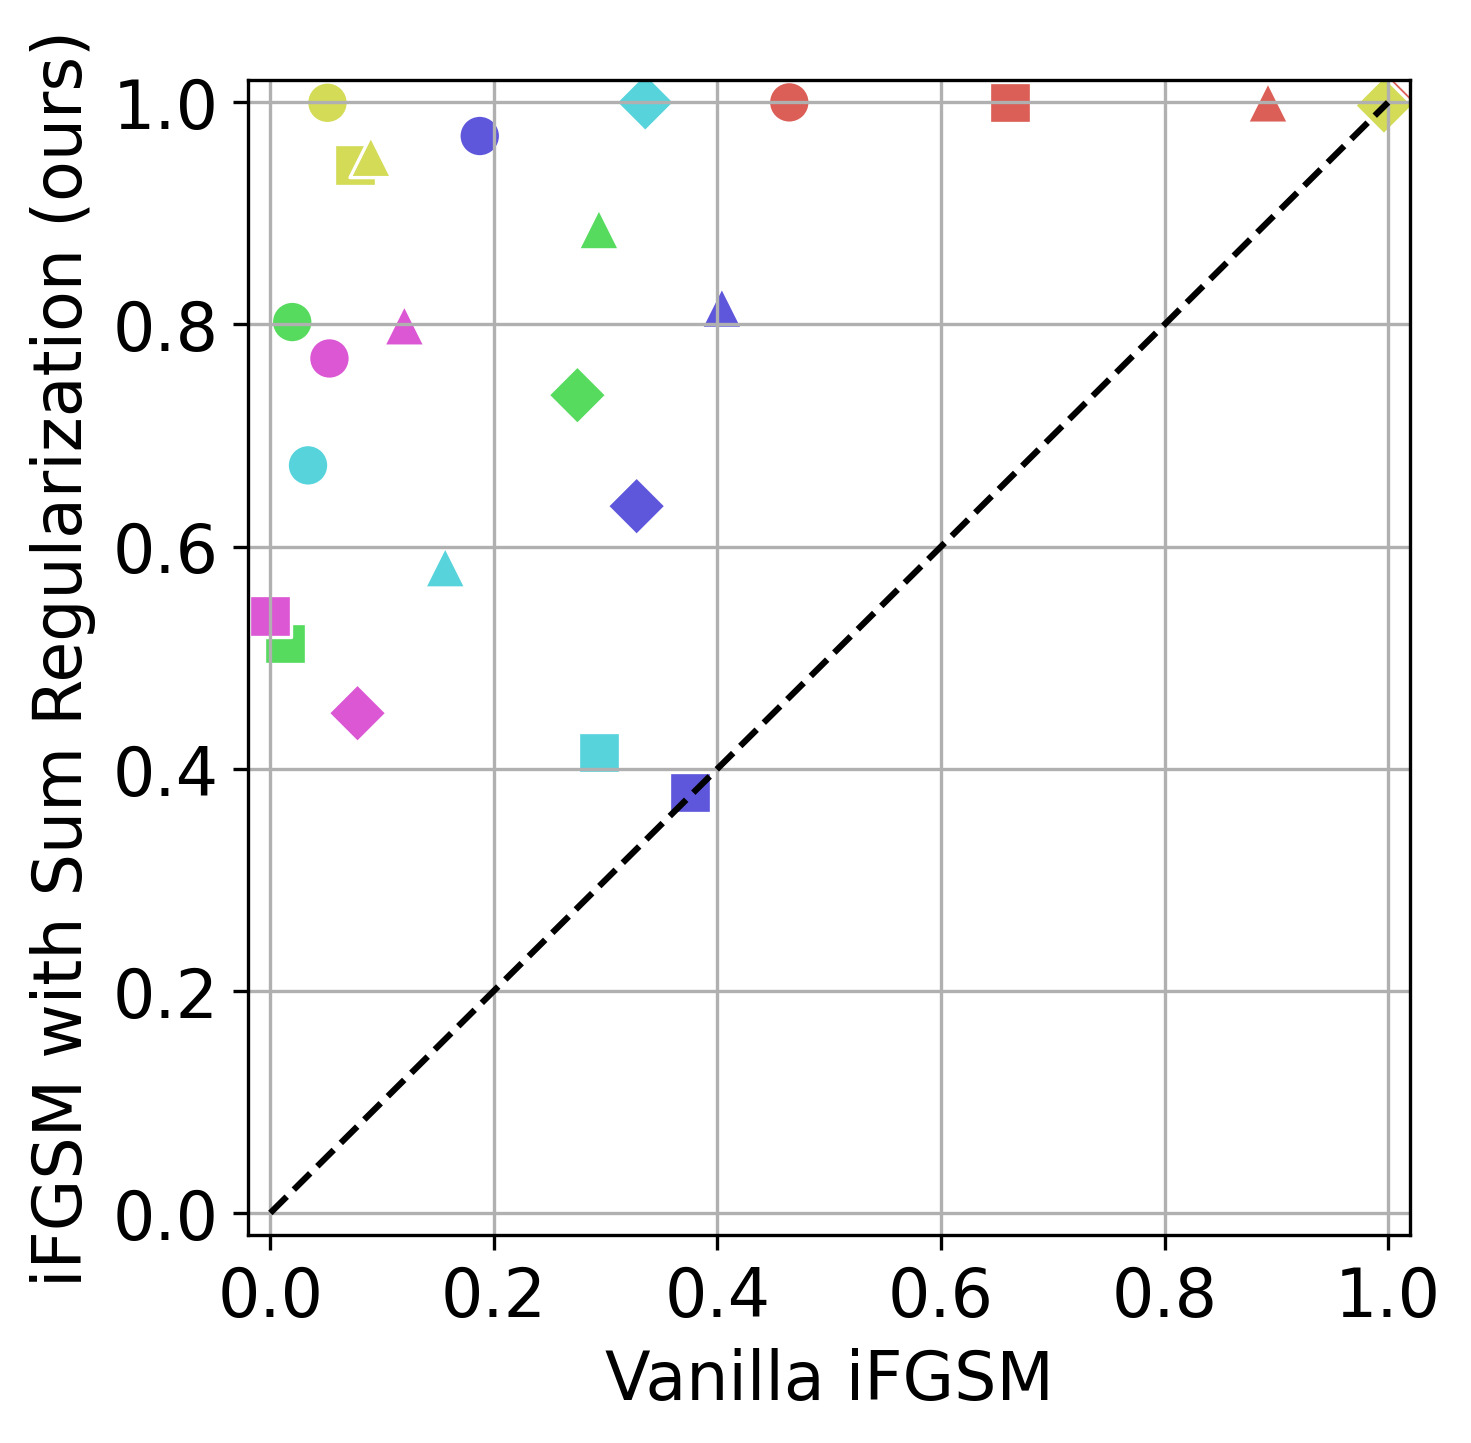

In [106]:
draw_scatter_pair_metrics(
    agg_data, 
    'fgsm', 
    'fgsm_disc', 
    x_col_name='Vanilla iFGSM', 
    y_col_name='iFGSM with Sum Regularization (ours)', 
    title='', 
    fontsize=16,
    legend=False,
    savepath='../pictures/ifgsm_van.pdf'
)

/tmp/ipykernel_8500/361734870.py:25: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


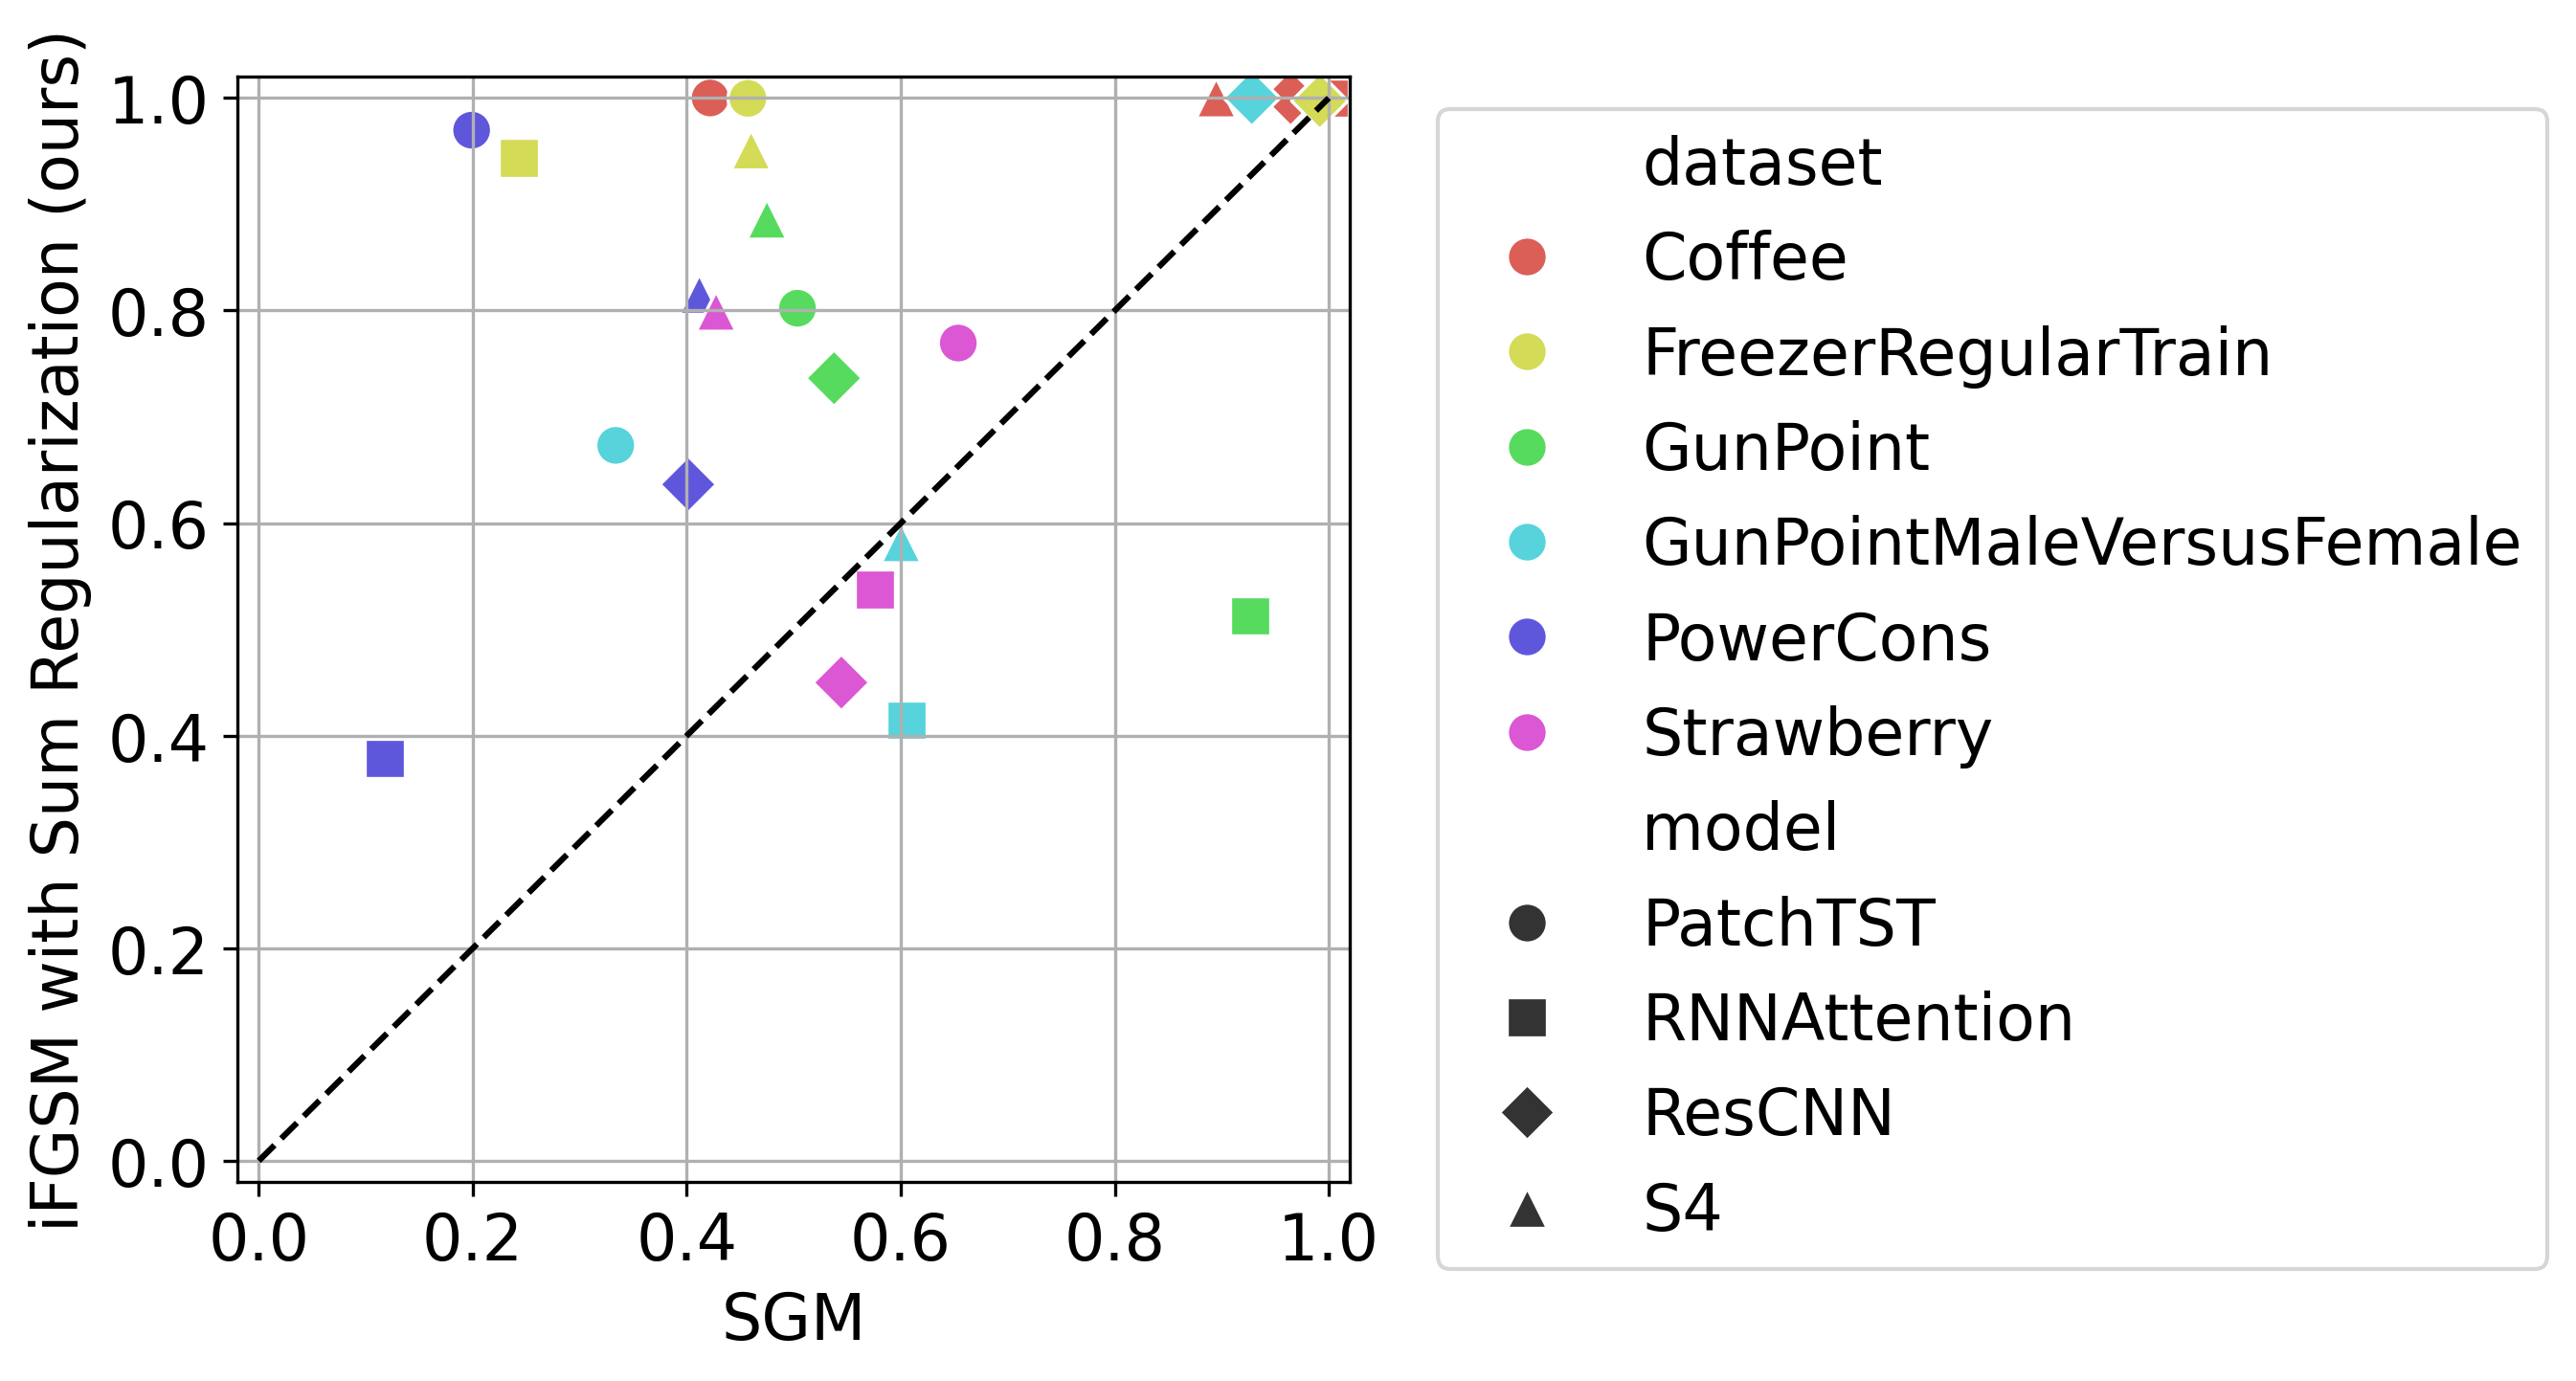

In [107]:
# draw_scatter_pair_metrics(agg_data, 'kll2', 'fgsm_disc', x_col_name='SGM', y_col_name='iFGSM with Sum Regularization (ours)', title='', legend=True)

draw_scatter_pair_metrics(
    agg_data, 
    'kll2', 
    'fgsm_disc', 
    x_col_name='SGM', 
    y_col_name='iFGSM with Sum Regularization (ours)', 
    title='', 
    fontsize=16,
    legend=True,
    savepath='../pictures/ifgsm_kll2.pdf'
)

/tmp/ipykernel_8500/361734870.py:25: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


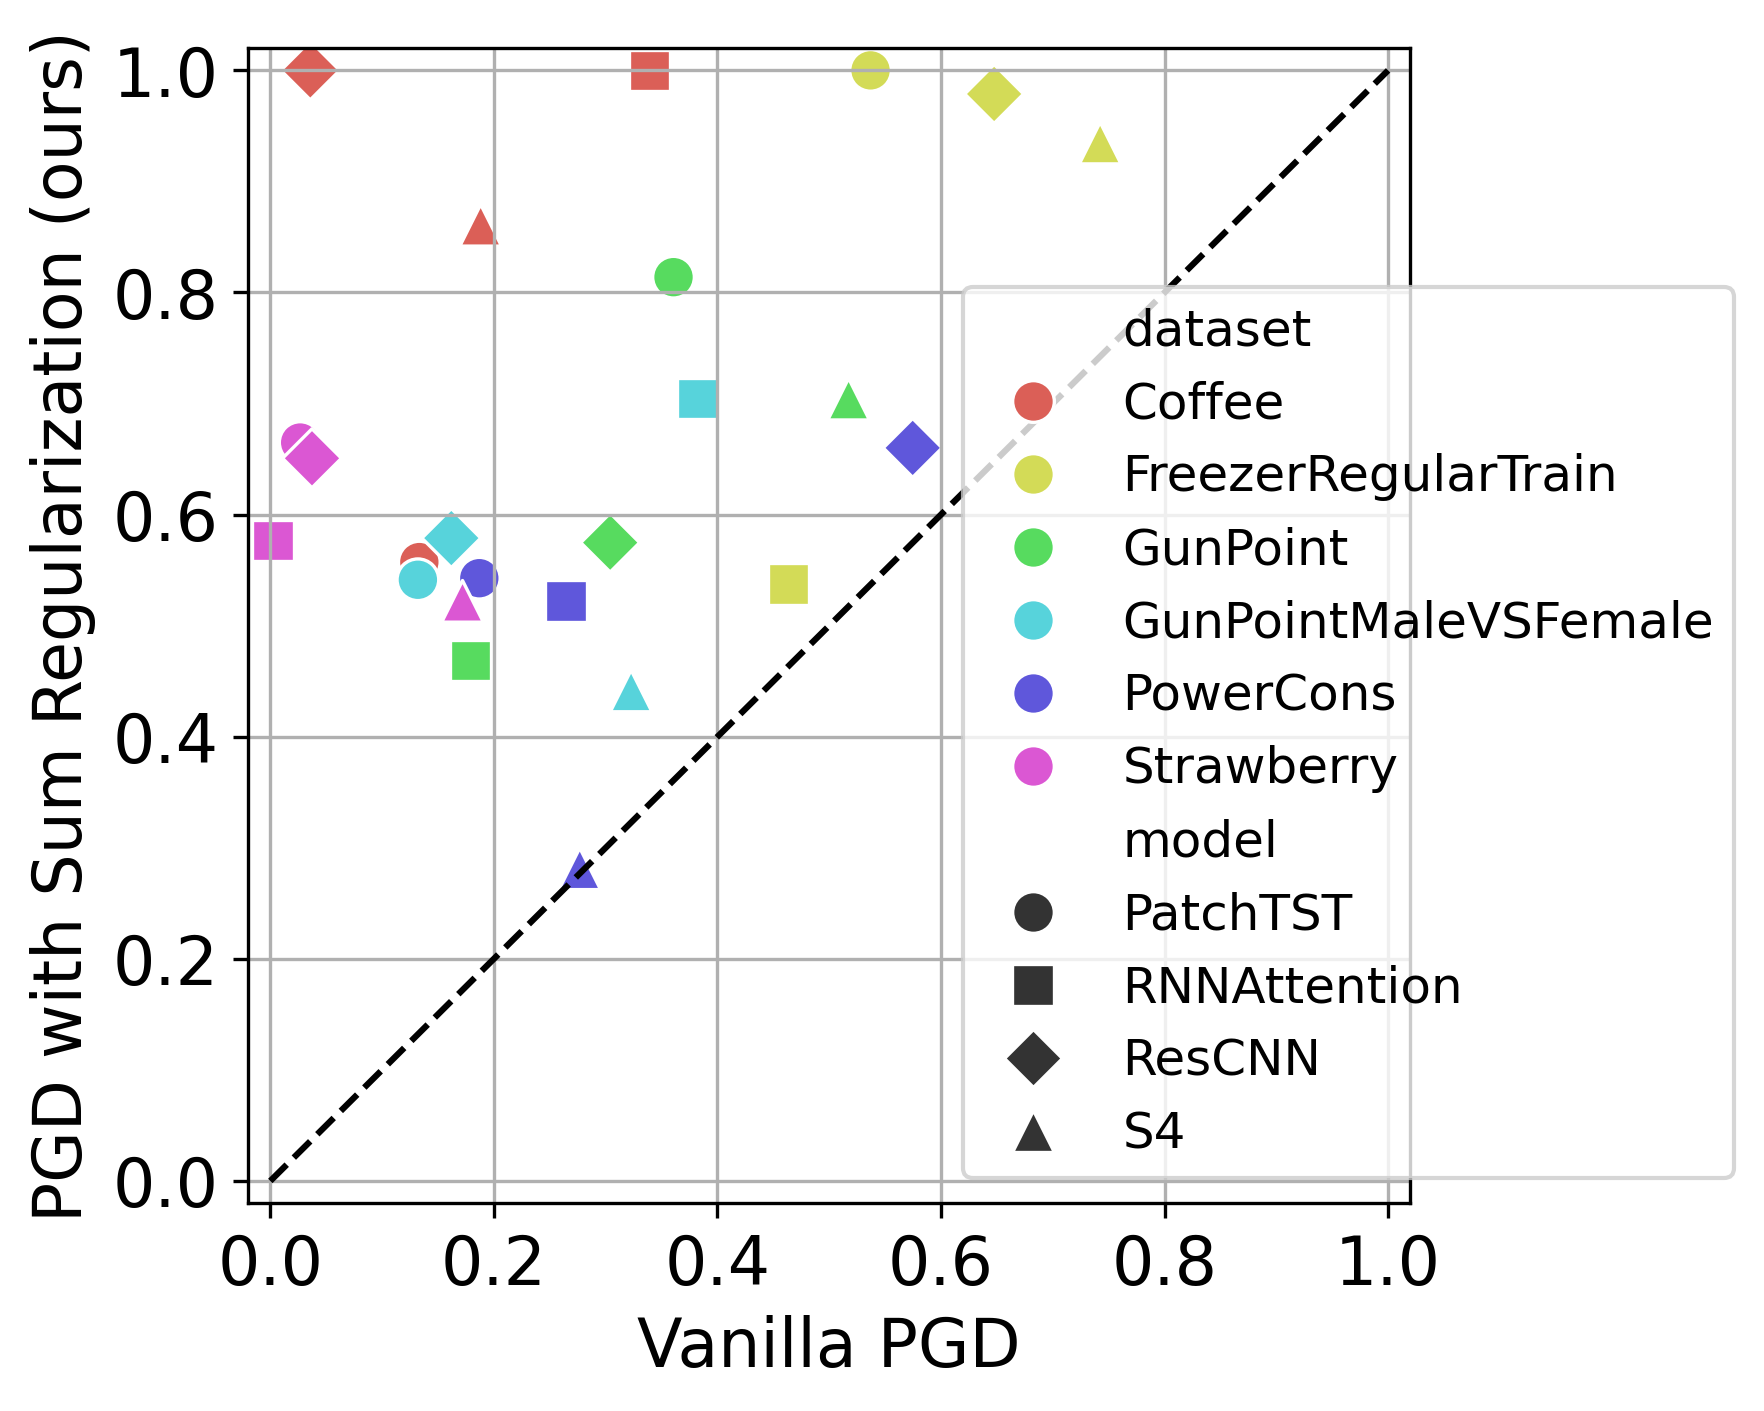

In [108]:
# draw_scatter_pair_metrics(
#     agg_data, 
#     'pgd', 'pgd_disc', x_col_name='Vanilla PGD', y_col_name='PGD with Sum Regularization (ours)', title='')


draw_scatter_pair_metrics(
    agg_data.replace('GunPointMaleVersusFemale', "GunPointMaleVSFemale"), 
    'pgd', 
    'pgd_disc', 
    x_col_name='Vanilla PGD', 
    y_col_name='PGD with Sum Regularization (ours)', 
    title='', 
    fontsize=16,
    legend=True,
    legend_position='in',
    savepath='../pictures/pgd_vanilla.pdf'
)

In [24]:
raise ValueError

ValueError: 

# Examples

In [1]:
# changing core directory
import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [2]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# from src.attacks import fgsm_attack, only_disc_attack
# from src.attacks.utils import calculate_metrics_class_and_hiddens, req_grad
from src.config import get_disc_list
from src.data import MyDataset, load_data, transform_data
from src.models.LSTM import LSTM
# from src.utils import load_disc_model

/home/adversarial_attacks_petr/miniconda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [3]:
from hydra import compose, initialize
from omegaconf import OmegaConf
initialize(config_path='../config', version_base=None)
cfg = compose(config_name='attack_run_config.yaml')
print(OmegaConf.to_yaml(cfg))

dataset:
  name: PowerCons
  num_classes: 2
  seq_len: 144
  total_object_count: 360
  train:
    object_count: 180
    max: 6.150072421276428
    mean: -1.7736155479814228e-16
    min: -0.9882441283924925
    std: 0.9999999999999999
    median: -0.4639090210070178
    roughness: 0.15408237025050991
  test:
    object_count: 180
    max: 6.002890636747172
    mean: -0.010892417367795152
    min: -1.0250395745248067
    std: 0.9910649059168454
    median: -0.4823067440731748
    roughness: 0.1544105925399531
attack_model:
  name: ResidualCNN
  params:
    c_in: 1
    c_out: 1
    coord: false
    separable: false
    zero_norm: false
  hyperparameters_vary:
    c_in:
      optuna_type: const
      value: 1
    c_out:
      optuna_type: const
      value: 1
  attack_train_mode: false
disc_model_reg:
  name: ResidualCNN
  params:
    c_in: 1
    c_out: 1
    coord: false
    separable: false
    zero_norm: false
  hyperparameters_vary:
    c_in:
      optuna_type: const
      value: 1
   

In [4]:
import os
import warnings

import hydra
import pandas as pd
import torch
from omegaconf import DictConfig
from torch.utils.data import DataLoader

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator
from src.utils import fix_seed, save_attack_metrics, save_config, save_compiled_config,weights_from_clearml_by_name
fix_seed(cfg['model_id_attack'])

In [5]:
X_train, y_train, X_test, y_test = load_data(cfg["dataset"]["name"])
X_train, X_test, y_train, y_test = transform_data(
    X_train, X_test, y_train, y_test, slice_data=cfg["slice"]
)

test_loader = DataLoader(
    MyDataset(X_test, y_test), batch_size=cfg["batch_size"], shuffle=False
)

device = torch.device(cfg["device"] if torch.cuda.is_available() else "cpu")

attack_model_path = os.path.join(
    cfg["model_folder"],
    cfg["attack_model"]["name"],
    f"model_{cfg['model_id_attack']}_{cfg['dataset']}.pt",
)

attack_model_path = os.path.join(
cfg["model_folder"],
f"model_{cfg['attack_model']['name']}_{cfg['model_id_attack']}_{cfg['dataset']['name']}.pt")

attack_model = get_model(
    cfg["attack_model"]["name"],
    cfg["attack_model"]["params"],
    path=attack_model_path,
    device=device,
    train_mode=cfg["attack_model"]["attack_train_mode"],
)

In [6]:
criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])

disc_check_list = (
    get_disc_list(
        model_name=cfg["disc_model_check"]["name"],
        model_params=cfg["disc_model_check"]["params"],
        list_disc_params=cfg["list_check_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=False,
    )
    if cfg["use_disc_check"]
    else None
)
estimator = AttackEstimator(disc_check_list, cfg["metric_effect"])

In [7]:
alpha = 1
eps = 0.03

In [8]:
cfg["attack"]["name"] = 'FGSMAttack'

attack_params = dict(cfg["attack"]["attack_params"])
attack_params["model"] = attack_model
attack_params["criterion"] = criterion
attack_params["estimator"] = estimator
attack_params["alpha"] = alpha
attack_params["eps"] = eps

if "list_reg_model_params" in cfg["attack"]:
    attack_params["disc_models"] = get_disc_list(
        model_name=cfg["disc_model_reg"]["name"],
        model_params=cfg["disc_model_reg"]["params"],
        list_disc_params=cfg["attack"]["list_reg_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=cfg["disc_model_reg"]["attack_train_mode"],
    )

attack = get_attack(cfg["attack"]["name"], attack_params)
X_adv = attack.apply_attack(test_loader).squeeze(-1)

logging


100%|██████████| 50/50 [00:01<00:00, 31.51it/s]


In [9]:
cfg["attack"]["name"] = 'FGSMRegDiscAttack'

attack_params = dict(cfg["attack"]["attack_params"])
attack_params["model"] = attack_model
attack_params["criterion"] = criterion
attack_params["estimator"] = estimator
attack_params["alpha"] = alpha
attack_params["eps"] = eps

if "list_reg_model_params" in cfg["attack"]:
    attack_params["disc_models"] = get_disc_list(
        model_name=cfg["disc_model_reg"]["name"],
        model_params=cfg["disc_model_reg"]["params"],
        list_disc_params=cfg["attack"]["list_reg_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=cfg["disc_model_reg"]["attack_train_mode"],
    )

attack = get_attack(cfg["attack"]["name"], attack_params)
X_adv_reg = attack.apply_attack(test_loader).squeeze(-1)

logging


100%|██████████| 50/50 [00:02<00:00, 24.48it/s]


In [10]:
attack_model.eval().to('cpu')
disc_model = disc_check_list[0].eval().to('cpu')

Original label 0; pred 0.319; pred attack 0.984; pred reg attack0.324
 Disc pred 0.0; pred attack 0.517; pred reg attack 0.0


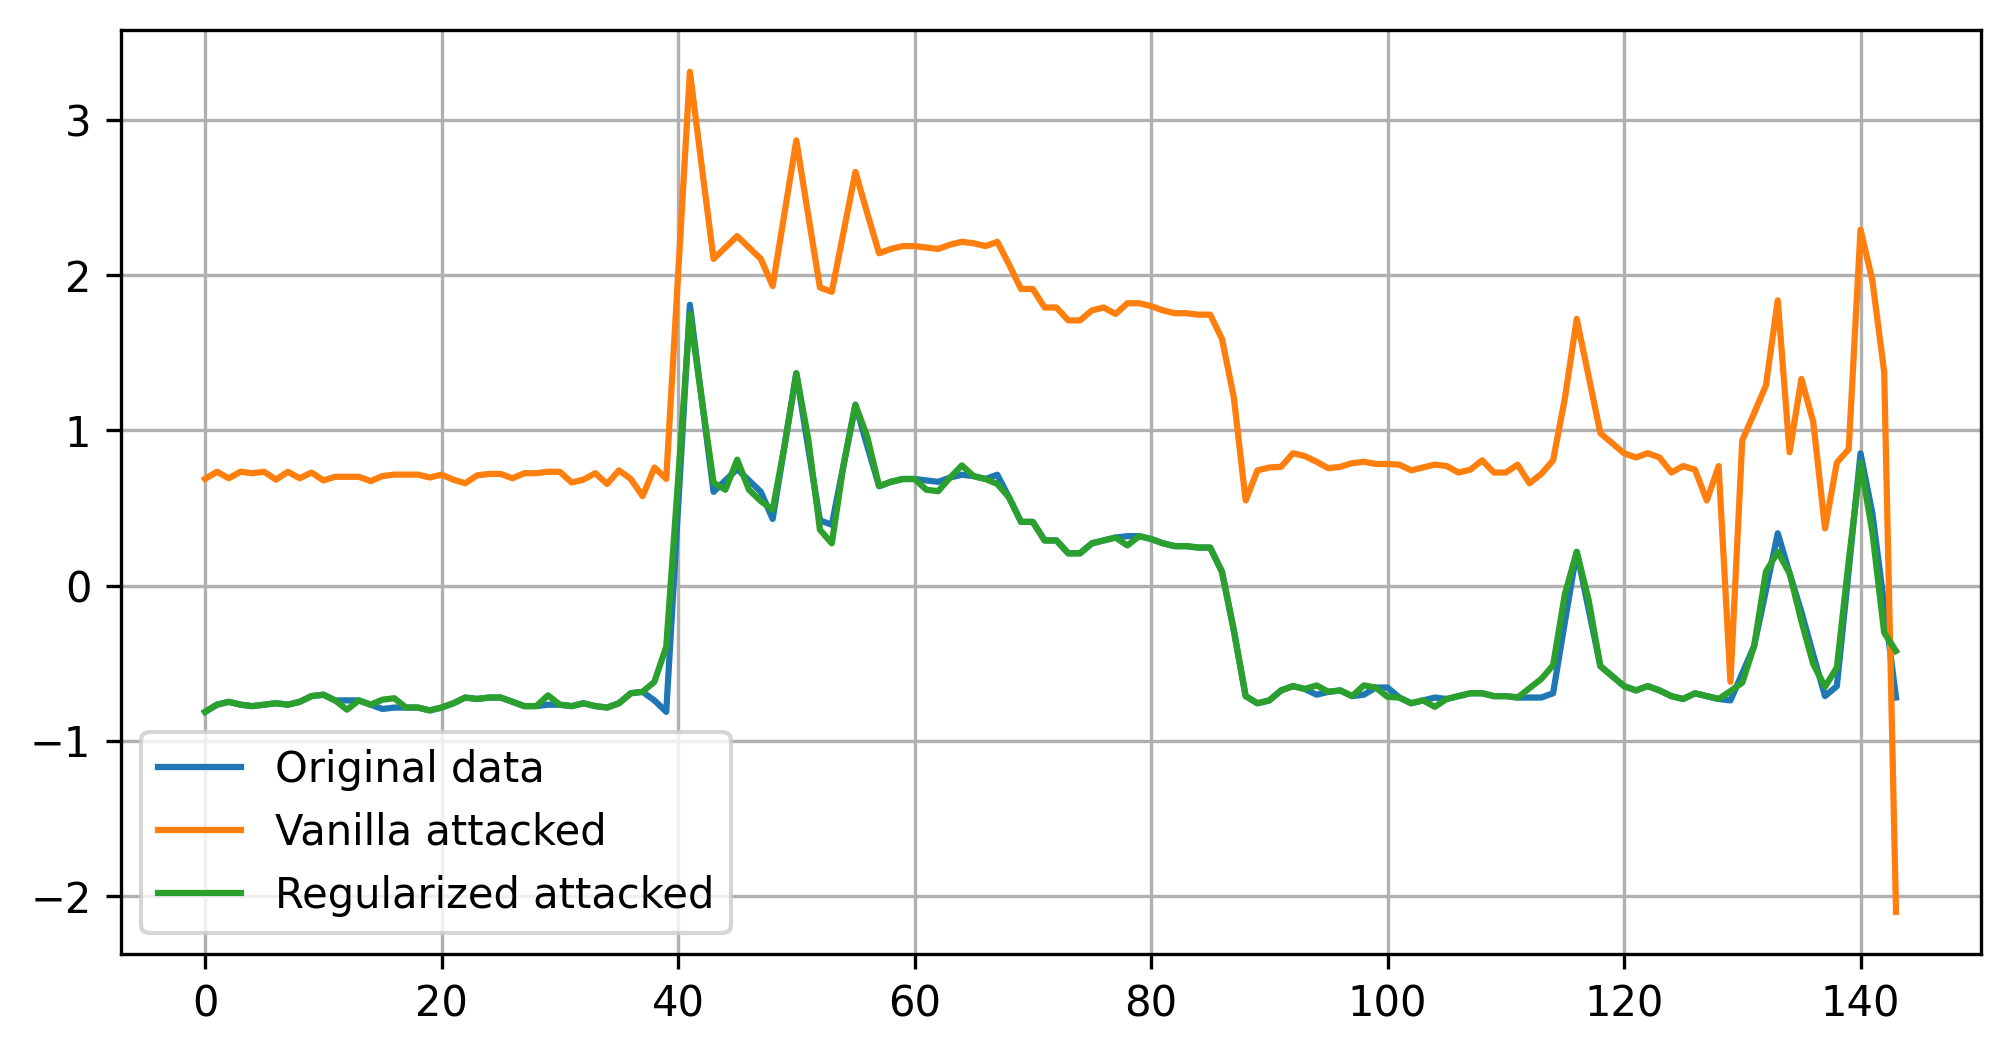

In [21]:
obj_id = 12

orig_obj = X_test[obj_id]
adv_obj = X_adv[obj_id]
adv_reg_obj = X_adv_reg[obj_id]

true_label = y_test[obj_id].numpy()[0]
pred_target_orig = attack_model(orig_obj.reshape(1, -1, 1)).detach().numpy()[0][0]
pred_target_adv= attack_model(adv_obj.reshape(1, -1, 1)).detach().numpy()[0][0]

pred_disc_orig = disc_model(orig_obj.reshape(1, -1, 1)).detach().numpy()[0][0]
pred_disc_adv= disc_model(adv_obj.reshape(1, -1, 1)).detach().numpy()[0][0]

pred_target_reg_adv= attack_model(adv_reg_obj.reshape(1, -1, 1)).detach().numpy()[0][0]
pred_disc_reg_adv= disc_model(adv_reg_obj.reshape(1, -1, 1)).detach().numpy()[0][0]

vals = [pred_target_orig, pred_target_adv, pred_target_reg_adv, pred_disc_orig, pred_disc_adv, pred_disc_reg_adv,]
round_vals = [str(round(x, 3)) for x in vals]

print(
    f'Original label {true_label}; pred {round_vals[0]}; pred attack {round_vals[1]}; pred reg attack{round_vals[2]}\n', 
    f'Disc pred {round_vals[3]}; pred attack {round_vals[4]}; pred reg attack {round_vals[5]}'
)

plt.figure(figsize=(8, 4), dpi=300)
plt.plot(orig_obj, label='Original data')
plt.plot(adv_obj, label='Vanilla attacked')
plt.plot(adv_reg_obj, label='Regularized attacked')
plt.legend()
plt.grid()
plt.show()

In [17]:
round(pred_target_orig, 3)

0.319

In [19]:
round_vals

[0.319, 0.984, 0.324, 0.0, 0.517, 0.0]